In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def phi_tanh(x):
    return np.tanh(x)

def dphi_tanh(x):
    t = np.tanh(x)
    return 1.0 - t*t

def make_J(N, seed_J=0):
    rng = np.random.RandomState(seed_J)
    return rng.randn(N, N) / np.sqrt(N)

def make_bias(N, sigma_I=0.03, seed_I=1):
    rng = np.random.RandomState(seed_I)
    return sigma_I * rng.randn(N)

def make_x0(N, scale=0.1, seed_x0=2):
    rng = np.random.RandomState(seed_x0)
    return scale * rng.randn(N)

def make_v0(N, seed_v0=3):
    rng = np.random.RandomState(seed_v0)
    v = rng.randn(N)
    return v / (np.linalg.norm(v) + 1e-32)


def step(x, J, g, tau, dt, I_vec):
    ph = phi_tanh(x)
    return x + dt * ((-x + g * (J @ ph) + I_vec) / tau)

def compute_trajectory(J, I_vec, g, tau, dt, T, warmup, x0, record_stride=1):
    steps_warm = int(np.round(warmup / dt))
    steps_sim  = int(np.round(T / dt))
    x = np.copy(x0)
    t = 0.0

    # warmup
    for _ in range(steps_warm):
        x = step(x, J, g, tau, dt, I_vec)
        t += dt

    # simulate
    S  = steps_sim // record_stride
    Xs = np.empty((S, J.shape[0]))
    ts = np.empty(S)
    k  = 0
    for s in range(steps_sim):
        x = step(x, J, g, tau, dt, I_vec)
        t += dt
        if (s + 1) % record_stride == 0:
            Xs[k] = x
            ts[k] = t
            k += 1
    return Xs, ts

def compute_autocorr(Xs, max_lag=2000, stride=1):
    X = Xs - Xs.mean(axis=0, keepdims=True)
    T = X.shape[0]
    L = max_lag // stride + 1
    ac = np.zeros(L)
    denom = (X**2).sum(axis=0).mean()
    for ell in range(L):
        lag = ell * stride
        if lag >= T:
            break
        prod = (X[lag:] * X[:T-lag]).sum(axis=0).mean()
        ac[ell] = prod / denom
    lags = np.arange(L) * stride
    return ac, lags

def compute_lyapunov(J, I_vec, g, tau, dt, T, warmup, x0, v0, reorth_every=10, eps0=1e-7):
    # warmup
    steps_warm = int(np.round(warmup / dt))
    x = np.copy(x0)
    v = np.copy(v0)
    for _ in range(steps_warm):
        x = step(x, J, g, tau, dt, I_vec)

    steps = int(np.round(T / dt))
    accum = 0.0
    count = 0
    for s in range(steps):
        x = step(x, J, g, tau, dt, I_vec)

        dph = dphi_tanh(x)
        w = J @ (dph * v)
        dv = (-v + g * w) / tau
        v  = v + dt * dv

        if (s + 1) % reorth_every == 0:
            norm_v = np.linalg.norm(v) + 1e-32
            accum += np.log(norm_v / eps0)
            count += 1
            v = (eps0 / norm_v) * v

    return accum / (count * reorth_every * dt) if count > 0 else float('nan')


def plot_trajectories(ts, Xs, neuron_idx=None, max_traces=5, title=None):

    if neuron_idx is None:
        neuron_idx = np.arange(min(max_traces, Xs.shape[1]))

    plt.figure(figsize=(6,4))  
    
    for i in neuron_idx:
        plt.plot(ts, Xs[:, i], label=f"unit {i+1}", lw=1.5, alpha=0.9)

    plt.xlabel("time", fontsize=12)
    plt.ylabel(r"$h_i(t)$", fontsize=12)

    if title:
        plt.title(title, fontsize=13)

    plt.grid(True, which="both", linestyle="--", alpha=0.4)

    if len(neuron_idx) <= 10:
        plt.legend(frameon=False, fontsize=9)

    plt.tight_layout()
    plt.show()


def plot_lyapunov(g_vals, lam_vals, title=None):
    plt.figure(figsize=(8,4.5))
    plt.plot(g_vals, lam_vals, marker="o")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("g")
    plt.ylabel("Largest Lyapunov exponent (1/time)")
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/87/_88j16k118z6hwpfvycnp0rc0000gn/T/ipykernel_18938/1357064526.py:16: SyntaxWarning: invalid escape sequence '\s'
  plot_trajectories(ts, Xs, max_traces=100, title=f"Trajectories at g={g_traj} and $\sigma_b$ = {sigma_I}")


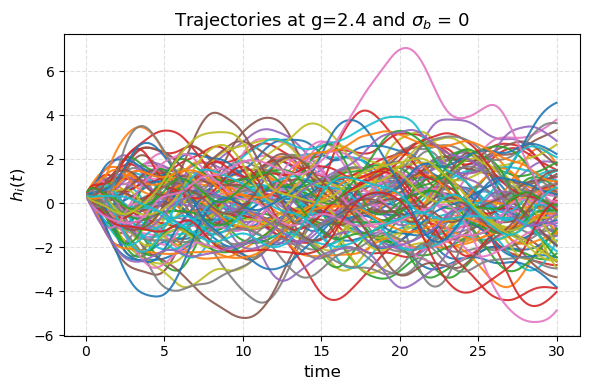

In [8]:
N = 2000
tau = 1.0
dt = 0.1
sigma_I = 0

J = make_J(N, seed_J=0)
I_vec = make_bias(N, sigma_I=sigma_I, seed_I=1)
x0 = 0.4 + 0*make_x0(N, scale=0.1, seed_x0=2)
v0 = make_v0(N, seed_v0=3)


g_traj = 2.4
T = 30.0
warmup = 0.0
Xs, ts = compute_trajectory(J, I_vec, g_traj, tau, dt, T, warmup, x0, record_stride=1)
plot_trajectories(ts, Xs, max_traces=100, title=f"Trajectories at g={g_traj} and $\sigma_b$ = {sigma_I}")



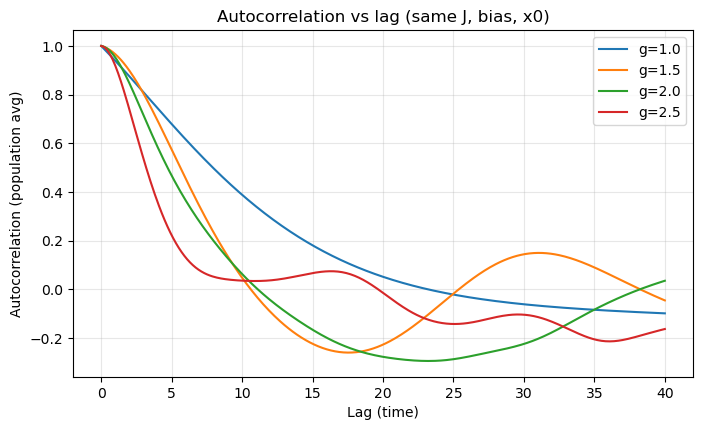

In [ ]:
#AUTOCORRELATION PLOT
g_list = [1.0, 1.5, 2.0, 2.5]
max_lag_steps = 400


plt.figure(figsize=(8,4.5))
for g in g_list:
    Xs_g, ts_g = compute_trajectory(J, I_vec, g, tau, dt, T, warmup, x0, record_stride=1)
    ac, lags = compute_autocorr(Xs_g, max_lag=max_lag_steps, stride=1)
    plt.plot(lags*dt, ac, label=f"g={g}")
plt.xlabel("Lag (time)")
plt.ylabel("Autocorrelation (population avg)")
plt.title("Autocorrelation vs lag (same J, bias, x0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


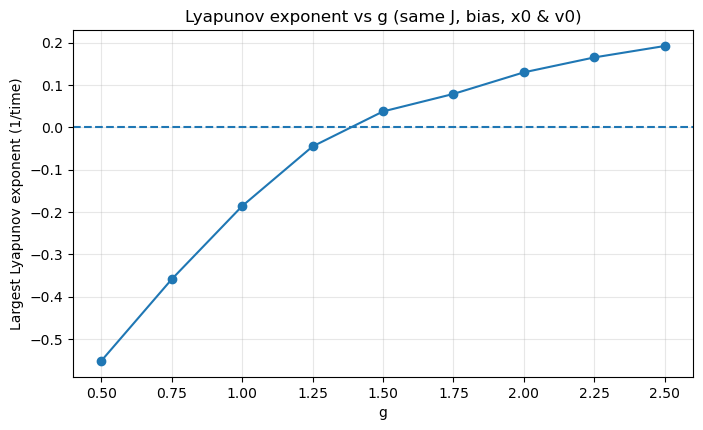

In [44]:
#MAX LYAPUNOV
N = 1000
tau = 1.0
dt = 0.1
sigma_I = 0.5

J = make_J(N, seed_J=0)
I_vec = make_bias(N, sigma_I=sigma_I, seed_I=1)
x0 = make_x0(N, scale=0.1, seed_x0=2)
v0 = make_v0(N, seed_v0=3)

g_vals = np.linspace(.5, 2.5, 9)
lam_vals = []
for g in g_vals:
    lam = compute_lyapunov(J, I_vec, g, tau, dt, T=250.0, warmup=50.0, x0=x0, v0=v0,
                           reorth_every=10, eps0=1e-7)
    lam_vals.append(lam)

plot_lyapunov(g_vals, lam_vals, title="Lyapunov exponent vs g (same J, bias, x0 & v0)")

Text(0, 0.5, 'Lyapunov')

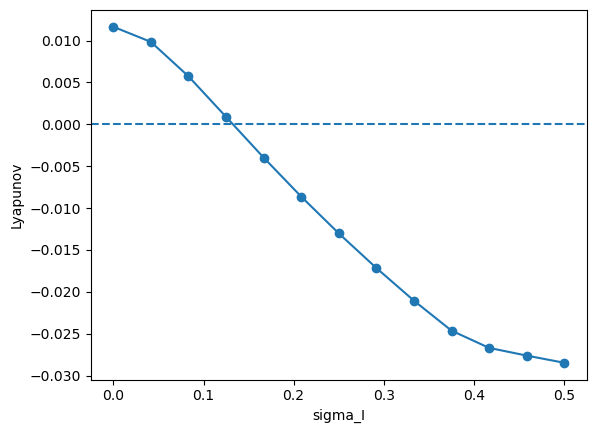

In [ ]:

rng = np.random.RandomState(123)
u = rng.randn(N); u /= np.linalg.norm(u)

sigma_grid = np.linspace(0.0, 0.5, 13)
g = 1.0

lam = []
phi_prime_avg = []
for sigma_I in sigma_grid:
    I_vec = sigma_I * u
    lam.append(compute_lyapunov(J, I_vec, g, tau, dt, T=600.0, warmup=100.0,
                                x0=x0, v0=v0, reorth_every=10))
    Xs, _ = compute_trajectory(J, I_vec, g, tau, dt, T=600.0, warmup=100.0, x0=x0)

plt.figure(); plt.plot(sigma_grid, lam, marker='o'); plt.axhline(0, ls='--'); plt.xlabel('sigma_I'); plt.ylabel('Lyapunov')

In [ ]:

N=800; tau=1.0; dt=0.05
T=900.0; warmup=180.0
seed_J=0; seed_x0=2; seed_v0=3; seed_bias_dir=123

J  = make_J(N, seed_J)
x0 = make_x0(N, scale=0.1, seed_x0=seed_x0)
v0 = make_v0(N, seed_v0)

rng = np.random.RandomState(seed_bias_dir)
u = rng.randn(N); u_dir = u/np.std(u)     

def find_gc(J, u_dir, sigma_I, g_lo=0.7, g_hi=3.0, tol=1e-3, max_iter=20):
    
    I_vec = sigma_I * u_dir
    lam_lo = compute_lyapunov(J, I_vec, g_lo, tau, dt, T, warmup, x0, v0)
    lam_hi = compute_lyapunov(J, I_vec, g_hi, tau, dt, T, warmup, x0, v0)
    if lam_lo >= 0: return g_lo
    if lam_hi <= 0: return np.nan
    lo, hi = g_lo, g_hi
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        lam = compute_lyapunov(J, I_vec, mid, tau, dt, T, warmup, x0, v0)
        if lam > 0: hi = mid
        else:       lo = mid
        if hi-lo < tol: break
    return 0.5*(lo+hi)

sigma_grid = np.linspace(0.0, 0.5, 7)
gcs = []
lo, hi = 0.7, 2.0
for i, sigma_I in enumerate(sigma_grid):
    if i>0:
        lo = max(0.7, gcs[-1]-0.2); hi = min(3.0, max(gcs[-1]+0.2, lo+0.2))
    gcs.append(find_gc(J, u_dir, sigma_I, g_lo=lo, g_hi=hi))



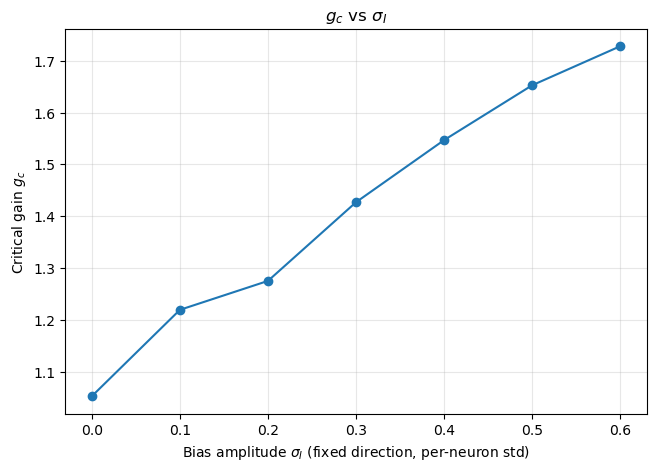

In [48]:
plt.figure(figsize=(7.5,5))
plt.plot(sigma_grid, gcs, marker="o")
plt.xlabel(r"Bias amplitude $\sigma_I$ (fixed direction, per-neuron std)")
plt.ylabel(r"Critical gain $g_c$")
plt.title(r"$g_c$ vs $\sigma_I$")
plt.grid(True, alpha=0.3)
plt.show()